# Purpose

This notebook largely serves to allow me to sift through all of the chargemasters and metadata generated via the work already done in [this wonderful repo](https://github.com/vsoch/hospital-chargemaster) (from which I forked my repo). 

Based upon the originating repo's own README, there's at least some data collection that still needs to be done (e.g. [data from hospitalpriceindex.com](https://search.hospitalpriceindex.com/hospital/Barnes-Jewish-Hospital/5359?page=1) has to be scraped but they're denying IP addresses that try to do so). However, if any of that gets done in here, it won't be until after I've sifted through the current material to make sure I have a handle on what data are already available. 

It's fairly plausible that I'll then attempt to combine it all into a single sqlite or MongoDB database that can subsequently be analyzed. But I'm getting ahead of myself - first to figure out what we have to work with!

# Background

*Assume everything in this cell is quoted directly from the originating repo README, albeit with some extra content removed for the purposes of streamlining. Anything in italics like this should be assumed to be editorial additions by me.*

**From the original README:**

## Get List of Hospital Pages
We have compiled a list of hospitals and links in the [hospitals.tsv](hospitals.tsv) 
file, generated via the [0.get_hospitals.py](0.get_hospitals.py) script *which pulls these data from [a Quartz article](https://qz.com/1518545/price-lists-for-the-115-biggest-us-hospitals-new-transparency-law/) detailing ~115 hospital URLs from which the authors were able to find chargemasters in one form or another*. 

The file includes the following variables, separated by tabs:

 - **hospital_name** is the human friendly name
 - **hospital_url** is the human friendly URL, typically the page that includes a link to the data.
 - **hospital_id** is the unique identifier for the hospital, the hospital name, in lowercase, with spaces replaced with `-`
   
## Organize Data

Each hospital has records kept in a subfolder in the [data](data) folder. Specifically,
each subfolder is named according to the hospital name (made all lowercase, with spaces 
replaced with `-`). If a subfolder begins with an underscore, it means that I wasn't
able to find the charge list on the hospital site (and maybe you can help?) 
Within that folder, you will find:

 - `scrape.py`: A script to scrape the data
 - `browser.py`: If we need to interact with a browser, we use selenium to do this.
 - `latest`: a folder with the last scraped (latest data files)
 - `YYYY-MM-DD` folders, where each folder includes:
   - `records.json` the complete list of records scraped for a particular data
   - `*.csv` or `*.xlsx` or `*.json`: the scraped data files.

## Parsing
This is likely one of the hardest steps. I wanted to see the extent to which I could
create a simple parser that would generate a single TSV (tab separted value) file
per hospital, with minimally an identifier for a charge, and a price in dollars. If
provided, I would also include a description and code:

 - **charge_code**
 - **price**
 - **description**
 - **hospital_id**
 - **filename**

Each of these parsers is also in the hospital subfolder, and named as "parser.py." The parser would output a data-latest.tsv file at the top level of the folder, along with a dated (by year `data-<year>.tsv`). At some point
I realized that there were different kinds of charges, including inpatient, outpatient, DRG (diagnostic related group) and others called
"standard" or "average." I then went back and added an additional column
to the data:

 - **charge_type** can be one of standard, average, inpatient, outpatient, drg, or (if more detail is supplied) insured, uninsured, pharmacy, or supply. This is not a gold standard labeling but a best effort. If not specified, I labeled as standard, because this would be a good assumption.

# Exploratory Data Analysis (EDA)

OK, I think I have a handle on this, let's take a look at the data, starting with the hospital metadata.

It may be a bit confusing for anyone following along at home, but note that I had already started my own effort to download a bunch of these chargemasters in a far more manual approach than what @vsoch did with `BeautifulSoup` and all. As a result, I may be comparing her dataset at times in this notebook to the one I was developing. Mine was never going to have automated updates like hers however, hence why I'm deferring to her repo and data over my own (while mine may be a bit more comprehensive in terms of number of hospitals, I'd rather the data be up to date as much as possible). 

That said, as of this writing, I have approximately 600+ unique hospitals included in my chargemaster index, so I'm going to keep an eye out during my EDA to see if my more manual approach may still be useful.

## Metadata

In [ ]:
#Make sure any changes to custom packages can be reflected immediately 
#in the notebook without kernel restart
import autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
#Import the hospital metadata

import pandas as pd
metadata = pd.read_csv('hospitals.tsv', delimiter = r'\t')
metadata

In [ ]:
#Do these data include the huge CA chargemaster dataset on oshpd.ca.gov?
metadata[metadata['hospital_url'].str.contains('oshpd.ca.gov')]

*Interesting, it looks like this dataset may not include the full OSHPD chargemaster list.* I find that unlikely however, as @vsoch makes it clear in another part of her README that she built the `oshpd-ca` scraper and found 795+ hospitals in that dataset. **This suggests that this metadata file may not be complete, as it's really just an inventory of the links from the aforementioned Quartz article, and not necessarily a full accounting of the hospitals contained in the dataset.**

## Reading in the Tabulated Data

OK, so the metadata table wasn't super useful (investigating `data/oshpd-ca` confirmed that indeed there are far more files in this repo than hospitals listed in `hospitals.tsv`), but there are **a lot** of files to plow through here! And vsoch was kind enough to try and compile them whenever appropriate in the various hospital/site-specific folders within `data` as `data-latest[-n].tsv` (`-n` indicates that, if the file gets above 100 MB, it's split into `data-latest-1.tsv`, `data-latest-2.tsv`, etc. to avoid going over the GitHub per-file size limit).

Let's try to parse all of these TSV files into a single coherent DataFrame! The entire `data` folders is less than 4 GB, and I'm confident that more than half of that is individual XLSX/CSV files, so I think this should be something we can hold in memory easily enough.

...still, we'll use some tricks (e.g. making the sub-dataframes as a generator instead of a list) to ensure optimal memory usage, just to be safe.

In [ ]:
# Search through the data/hospital-id folders for data-latest[-n].tsv files
# so you can concatenate them into a single DataFrame
from glob import glob, iglob

for name in iglob('data/*/data-latest*.tsv'):
    print(name)

In [ ]:
# Setup the full dataframe using iterators/generators to save on memory
all_files = iglob('data/*/data-latest*.tsv')
individual_dfs = (pd.read_csv(f, delimiter = '\t', 
                              low_memory = False,
                             thousands = ',') for f in all_files)

df = pd.concat(individual_dfs, ignore_index=True)

In [ ]:
df.info(memory_usage = 'deep', verbose = True, null_counts = True)

In [ ]:
df.head()

**Not bad! At first I was a bit worried when I looked at this initial file in Excel, but Excel improperly interprets the thousands comma on prices as a new field delimiter.** This might work after all!

In [ ]:
df.tail()

In [ ]:
# Push out unoptimized CSV copy of dataframe so we don't need it to perpetually be in memory

df.to_csv('data/all_hospitals-latest.csv')

## Optimize the DataFrame

This dataframe is quite large (almost 4GB in memory!) and that's likely to cause all sorts of problems when it comes time to do analysis. So we'll need to make sure we understand the nature of each column's data and then optimize for it (after potentially correcting for things like strings that are actually numbers).

To start with, let's check out the nature of the data in each column:

1. How often do charge codes exist?
2. We'll check, but likely that description exists for most
3. Other than decimal numbers, what values are in price?
4. What are all of the different charge type values, and which ones can we filter out (e.g. drg)?
    * Do charge codes get embedded in descriptions a lot, like what we see in df.tail()? Or is this something that is only present for non-standard charge_type?

In [3]:
# In case you need to reinitialize df after experimenting...

#Make sure any changes to custom packages can be reflected immediately 
#in the notebook without kernel restart
import autoreload
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

df = pd.read_csv('data/all_hospitals-latest.csv', index_col = 0, low_memory = False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df.head()

,charge_code,price,description,hospital_id,filename,charge_type
0,NaN,1980,Adult semi-private (up to two patients) room a...,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
1,NaN,1980,Adult room and care in the Transitional Care H...,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
2,NaN,2310,Adult room and care on the Labor & Delivery unit,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
3,NaN,1980,Pediatric room and care,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard
4,NaN,2448,Psychiatric room and care,university-of-virginia-medical-center,university-of-virginia-medical-center.csv,standard


In [5]:
# First, let's get a better handle on unique values, so we can figure out what fields make
# sense as categoricals and what ones definitely don't

unique_vals = pd.DataFrame(df.nunique()).rename(columns = {0: 'number of unique values'})
unique_vals['fraction of all non-null values'] = round(unique_vals['number of unique values'] / len(df.dropna()), 2)
unique_vals['make categorical?'] = unique_vals['fraction of all non-null values'] < 0.5
unique_vals['data type'] = df.dtypes
unique_vals

,number of unique values,fraction of all non-null values,make categorical?,data type
charge_code,1615754,0.25,True,object
price,651547,0.10,True,object
description,2477488,0.38,True,object
hospital_id,379,0.00,True,object
filename,705,0.00,True,object
charge_type,12,0.00,True,object


In [6]:
unique_vals['fraction of all non-null values'] = round(unique_vals['number of unique values'] / len(df.dropna()), 2)
unique_vals

,number of unique values,fraction of all non-null values,make categorical?,data type
charge_code,1615754,0.25,True,object
price,651547,0.10,True,object
description,2477488,0.38,True,object
hospital_id,379,0.00,True,object
filename,705,0.00,True,object
charge_type,12,0.00,True,object


**Interesting. There are so many records with repeat information that we can change the dtype of pretty much all of them to be categorical.** Here's what we're going to do:

1. `charge_code`, `price`, and `description`: I'm not going to convert these to categoricals
    * `charge_code` and `description`: while from a data perspective these would likely be better handled in memory by making anything categorical that has so few unique values that the count of them is less than 50% of the count of all non-null rows, it doesn't make sense to make these fields categoricals, as that implies they are drawing from a common data reference. **That's simply not the case.** 
        * Given that two different hospitals can have the charge code `1001` refer to two totally different procedures/consumables, there's no reason to add confusion by treating these in the dataset like they have the same meaning. 
        * The same logic goes for the description field (although that one has me scratching my head a bit, as I'd expect it to be a bit more free text in nature and thus not likely to have repeated values)
    * `price`: this should be a continuous variable, not a categorical one!
2. `hospital_id`, `filename`, and `charge_type`: these are classic examples of categorical variables and we should convert them.

### Categorically Annoying

In [7]:
# Make categorical columns where appropriate
cat_cols = ['hospital_id', 'filename', 'charge_type']

for col in cat_cols:
    df.loc[:, col] = df.loc[:, col].astype('category')

df['charge_type'].cat.categories

Index(['drg', 'inpatient', 'insurance', 'insured-inpatient',
       'insured-outpatient', 'outpatient', 'pharmacy', 'standard', 'supply',
       'uninsured', 'uninsured-inpatient', 'uninsured-outpatient'],
      dtype='object')

In [8]:
df.info(memory_usage = 'deep', verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9907857 entries, 0 to 9907856
Data columns (total 6 columns):
charge_code    6563312 non-null object
price          8735057 non-null object
description    8745419 non-null object
hospital_id    9888293 non-null category
filename       9907857 non-null category
charge_type    9907857 non-null category
dtypes: category(3), object(3)
memory usage: 1.9 GB


**Nice! We cut the memory usage in half!** OK, on to less obvious optimizing!

### Description and Charge Code Fields

In [9]:
# What do our missing values look like? How sparse are these data?

missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total missing'})
missing['percent missing'] = round(missing['total missing'] / len(df),2)
missing.sort_values('total missing', ascending = False)
missing

,total missing,percent missing
charge_code,3344545,0.34
price,1172800,0.12
description,1162438,0.12
hospital_id,19564,0.00
filename,0,0.00
charge_type,0,0.00


**Looks like we have description text for all but 12% of the data.** Not bad.

In [10]:
# How often do charge codes exist?
df['charge_code'].describe()

count     6563312
unique    1615754
top          1001
freq        67961
Name: charge_code, dtype: object

In [11]:
df['charge_code'].value_counts()

1001                                                                                                                                                                                                                                                                                                               67961
C1776                                                                                                                                                                                                                                                                                                              39701
301.0                                                                                                                                                                                                                                                                                                              28355
361.0                                                        

**Quite a few different charge codes, with lots of different possible values.** Given that charge codes are likely a somewhat-random "unique" identifiers (air quotes because I'm suspicious of any large entity's data management practices until that suspicion is proven unwarranted). Nothing to see here.

*OK, let's get to the meat of it, the thing that's actually most interesting (arguably): the price!*

### The Price Column, AKA The Super Important Yet Extremely Messy Column

In [12]:
# Separate out only the price rows that are non-numeric

df['price'].dropna().apply(type).value_counts()

<class 'str'>    8735057
Name: price, dtype: int64

**So about half of the non-null prices are `str` type.** Now we need to figure out what those strings actually are.

In [13]:
# Look at only string prices

df.loc[df['price'].apply(type) == str,'price']

0               1980
1               1980
2               2310
3               1980
4               2448
5               1980
6               3917
7               6272
8               8010
9               8010
10              8010
11              6272
12              3971
13               356
14               587
15               940
16              1535
17              2808
18              4128
19               114
20               207
21               303
22               358
23               441
24               140
25               140
26               140
27               303
28               358
29               441
             ...    
9907827     42609.08
9907828     17784.24
9907829      53461.5
9907830     29037.21
9907831     41134.92
9907832     44698.45
9907833     18743.77
9907834     57341.27
9907835     17131.68
9907836     25042.51
9907837    120471.76
9907838       1393.0
9907839     22365.63
9907840     24346.83
9907841     11872.24
9907842     81348.51
9907843     6

**Huh, how odd. These strings all look like regular old float values.** Why is pandas importing them as strings? Let's force the column to be float type and then we'll see how our missing values change (since we can force non-numeric strings to be `NaN`)

In [14]:
# Convert price to be float type, then see if missing['total_missing'] changes

missing_price_initial = missing.loc['price','total missing']

delta = pd.to_numeric(df['price'], errors = 'coerce').isnull().sum() - missing_price_initial
delta

294073

**OK, so we see about 300K of the 4.67M string values become `NaN` when we do this numeric conversion. That's not ideal.** Looks like we're losing a lot of data with this conversion, is there a better way? Or should we just consider this an acceptable loss?

In [15]:
# How to filter so we can see a sample of the ~300K true non-float strings in price
# so we can get an idea as to how to deal with them?

# Show only the prices that are null after numeric conversion
df.loc[pd.to_numeric(df['price'], errors = 'coerce').isnull(), 'price']

762340      5,000
762342      1,768
762348      8,332
762349      2,758
762350      1,581
762352      2,126
762353      1,457
762357      2,125
762358      1,689
762361      4,949
762363      2,773
762364     13,801
762365      7,425
762366      8,035
762367      7,996
762370     32,926
762371     19,395
762372      2,831
762373     10,695
762400      1,019
762401      1,019
762406      1,248
762409      1,114
762414      4,519
762416      4,557
762419      6,418
762420     27,404
762421      8,976
762422      1,458
762423      6,418
            ...  
9897874      -   
9897876      -   
9897884      -   
9897902      -   
9897903      -   
9897912      -   
9897926      -   
9897945      -   
9897977      -   
9897978      -   
9898026      -   
9898027      -   
9898034      -   
9898037      -   
9898038      -   
9898041      -   
9898042      -   
9898052      -   
9898057      -   
9898058      -   
9898070      -   
9898081      -   
9898086      -   
9898096      -   
9898304   

**Ah, I see the issues here! We've got commas making numbers look like they're not numbers, and this weird ' -   ' string that must be a certain hospitals equivalent of `null`.** Let's correct for these!

The `null` string is one space, following by a hyphen and three spaces.

In [16]:
# Set ' -   ' to proper NaN

import numpy as np

df['price'].replace(' -   ', np.nan, inplace = True)

In [17]:
# What are the values that contain commas?

df.loc[df['price'].str.contains(r'\d,\d', na = False), 'price']

762340                      5,000
762342                      1,768
762348                      8,332
762349                      2,758
762350                      1,581
762352                      2,126
762353                      1,457
762357                      2,125
762358                      1,689
762361                      4,949
762363                      2,773
762364                     13,801
762365                      7,425
762366                      8,035
762367                      7,996
762370                     32,926
762371                     19,395
762372                      2,831
762373                     10,695
762400                      1,019
762401                      1,019
762406                      1,248
762409                      1,114
762414                      4,519
762416                      4,557
762419                      6,418
762420                     27,404
762421                      8,976
762422                      1,458
762423        

**Oh goodie, there are *ranges* of dollar amounts that we have to worry about!** Fantastic, just fantastic. These hospitals sure don't like making this easy, do they?

Here's the plan:
1. Strip dollar signs from all of these strings. They're superfluous and just make things complicated
2. Split strings on the string ' - '
3. Remove commas and cast results as float values
    * Any rows with `NaN` for the second split column are just regular comma-in-the-thousands-place numbers. Leave them alone for the moment
    * Any with non-null values in the second column: take the average of the two columns and overwrite the first column with the average. This midpoint value will be considered the useful estimate of the cost
4. Push the first column values (now overwritten in the case of ranges of values to be the midpoints) back into their places in the `price` column and continue hunting for edge cases

In [18]:
# Replace effectively null prices with np.nan

df.loc[df['price'] == '-', 'price'] = np.nan

In [19]:
def remove_silly_chars(row):
    '''
    It is assumed that this will be used as part of a Series.apply() call.
    
    Takes in an element of a pandas Series that should be a string representation 
    of a price or a range of prices and spits back the string without any thousands
    separators (e.g. commas) or dollar signs. If it detects that there's a range of
    prices being provided (e.g. $1.00 - $2.00), it returns the midpoint of the range.
    
    Parameters
    ----------
    row: str. The string representation of a price or range of prices.
    
    
    Returns
    -------
    float. The price (or midpoint price if a range was given in row)
    '''
    
    # Replace '$', ',', and '-' with empty strings, splitting on the hyphen
    price_strings = row.replace('$','').replace(',','').split('-')
    
    
    # Strip leading and trailing whitespace from list of split strings
    # and take the average of the different prices from the original range,
    # returning it as a float value
    
    # If ValueError raised, assume there were invalid characters and
    # set to np.nan
    
    try:
        return pd.Series([float(i.strip()) for i in price_strings]).mean()
    
    except ValueError: 
        return np.nan

In [20]:
# When only digits + commas + $, convert to only digits
# Also take average if multiple value range provided in string
ix = df['price'].str.contains(r'\d,\d|\$\d', na=False, case=False)
df.loc[ix, 'price'] = df.loc[ix,'price'].apply(remove_silly_chars)                             

**OK, now that we've cleaned up a lot of those strings so that they can be proper floats, how many bad strings are we left with?** When we ran this check prior to the `$` and `,` cleaning process, we had about 300K records coming up as null after the numeric conversion that weren't null previously. What does it look like now?

In [21]:
# Convert price to be float type, then see if missing['total_missing'] changes

missing_price_initial = missing.loc['price','total missing']

delta = pd.to_numeric(df['price'], errors = 'coerce').isnull().sum() - missing_price_initial
delta

206898

**SIGH. Now we're done to 200K, but that's not awesome.** At this point, I'm fine with it. We'll lose about 2.1% of these that may not appropriately be null (although most probably should be), but anything else I've tried to pare it down further actually makes things worse, so I say we're good now!

In [22]:
# Coerce any obvious float strings to floats
df.loc[:, 'price'] = pd.to_numeric(df['price'], errors = 'coerce')

In [23]:
df.info(memory_usage = 'deep', verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9907857 entries, 0 to 9907856
Data columns (total 6 columns):
charge_code    6563312 non-null object
price          8528159 non-null float64
description    8745419 non-null object
hospital_id    9888293 non-null category
filename       9907857 non-null category
charge_type    9907857 non-null category
dtypes: category(3), float64(1), object(2)
memory usage: 1.5 GB


In [24]:
df['price'].describe()

count    8.528159e+06
mean     8.959729e+06
std      1.928350e+08
min     -1.298600e+04
25%      1.590300e+02
50%      9.020000e+02
75%      4.449000e+03
max      1.000000e+10
Name: price, dtype: float64

**Ah nuts, looks like we have some unreasonable ranges on these data.** If I had to guess, likely these are issues with non-price floats being inserted into the `price` column incorrectly by individual hospital chargemaster parsers. Let's take a quick look at these data, identify the outliers, and see if we can fix them (and what the magnitude of the problem is).

In [28]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

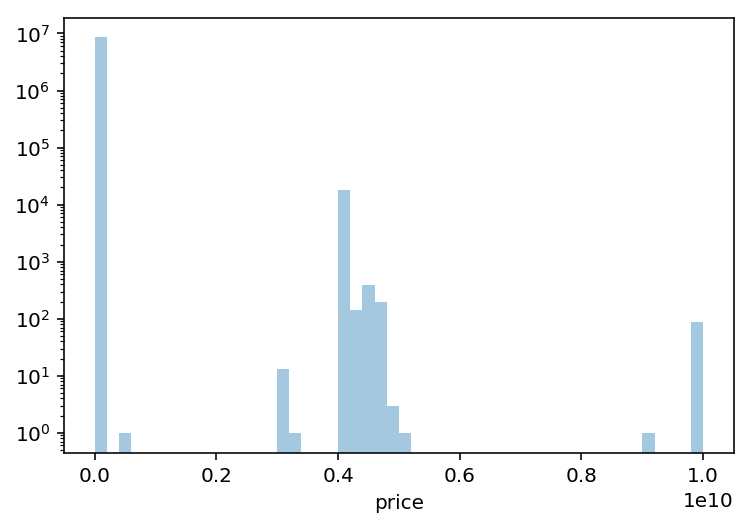

In [33]:
g = sns.distplot(df['price'].dropna(), kde = False)

g.axes.set_yscale('log')

**WHOA. The x-axis goes up to \\$10B USD?!** I'm going to assume that this is unreasonable...

In fact, looks like we have a non-trivial amount of data above \\$1B! That's ludicrous. Let's take a closer look in the \\$1M to \\$10B scale.

In [52]:
df.loc[(df['price'] >= 1E6) & (df['price'] <= 1E10), 'price'].describe()

count    1.871500e+04
mean     4.080677e+09
std      5.740180e+08
min      1.005042e+06
25%      4.050066e+09
50%      4.050233e+09
75%      4.090032e+09
max      1.000000e+10
Name: price, dtype: float64

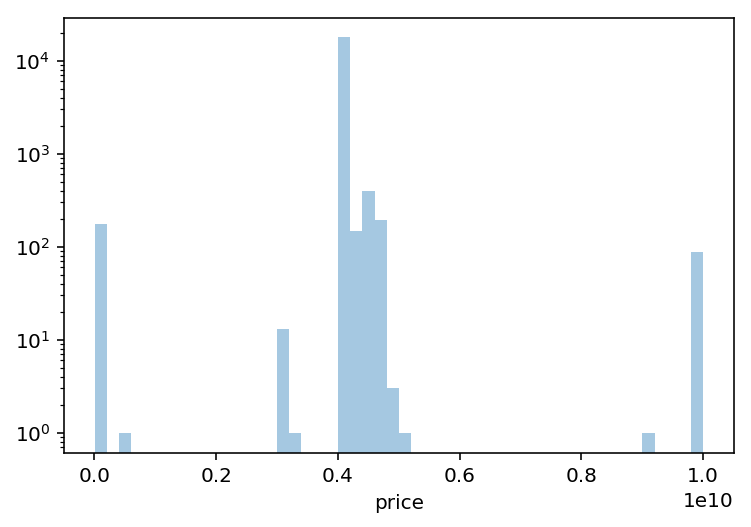

In [55]:
g = sns.distplot(df.loc[(df['price'] >= 1E6) & (df['price'] <= 1E10), 'price'].dropna(),
                 kde=False)

g.axes.set_yscale('log')

In [57]:
df.loc[(df['price'] >= 1E6) & (df['price'] <= 1E10), 'hospital_id'].value_counts()

foothill-presbyterian-hospital                      18568
uc-san-francisco-medical-center                        15
temple-university-hospital                             14
cedars-sinai-medical-center                            13
university-of-iowa-hospitals-and-clinics                8
university-of-colorado-hospital                         7
thomas-jefferson-university-hospital                    6
the-methodist-hospital-(houston)                        6
new-york-presbyterian-hospital                          5
chippenham-and-johnston-willis-medical-center           5
COVENANT MEDICAL CENTER                                 4
sunrise-hospital-and-medical-center                     4
rainbow-babies-and-childrens-hospital                   4
duke-raleigh-hospital                                   3
duke-university-hospital                                3
ronald-reagan-ucla-medical-center                       3
swedish-medical-center                                  3
BWH Standard C

**OK, so it's pretty clear to me here that we have a problem hospital here (foothill-presbyterian-hospital).** For simplicity's sake, we may just need to drop them from the dataset, but I'll take a look at their data and see if a fix is possible (I think it's a matter of switching the `price` and `charge_code` column data). 

For the other hospitals, the counts are so low that we can probably parse those out manually to make sure they aren't nonsensical.

**TO DO**

1. See if it's reasonable to switch `price` and `charge_code` data for foothill hospital. If it is, do so. If there's a problem, drop them from dataset.
2. Check out the other hospitals in this price range and see if there are persistent problems with their `price` data too that need to be corrected.
3. Look at how many records have `hospital_id` without any hyphens, like the last one in the list above. Clearly there's a problem with those...
4. Once you're satisfied that the data are clean, script up an `import_data` file and start up a new analysis-focused Jupyter notebook.
    * Subset by `charge_type == standard`
    * Cluster based on `description` similarity, and assume those are similar procedures/consumables
        * Figure out if there's a way to validate this
    * Do some analyses on price spreads and trends among the different clusters/procedures/consumables
    * Anything cool that can be predicted??